In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/kaggle/input/normal-bearing-data/normal_data.csv')
print(df.head())

# Since all data is normal (N), we'll use this for training
# In practice, you would have anomaly data for testing
X = df['DE_data'].values.reshape(-1, 1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

SEQ_LENGTH = 30  # Adjust based on your data characteristics
X_sequences = create_sequences(X_scaled, SEQ_LENGTH)

# Split into train and validation (no test since we only have normal data)
X_train, X_val = train_test_split(X_sequences, test_size=0.2, random_state=42)
print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}")

    DE_data fault
0  0.046104     N
1 -0.037134     N
2 -0.089496     N
3 -0.084906     N
4 -0.038594     N
Training shape: (387099, 30, 1), Validation shape: (96775, 30, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_4 (RepeatVector)       │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 30, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 164s 13ms/step - loss: 0.3484 - val_loss: 0.0977
Epoch 2/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 142s 12ms/step - loss: 0.0944 - val_loss: 0.1126
Epoch 3/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - loss: 0.0814 - val_loss: 0.0697
Epoch 4/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - loss: 0.0764 - val_loss: 0.0653
Epoch 5/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - loss: 0.0691 - val_loss: 0.0737
Epoch 6/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - loss: 0.0715 - val_loss: 0.0639
Epoch 7/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 142s 12ms/step - loss: 0.0623 - val_loss: 0.0697
Epoch 8/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - loss: 0.0629 - val_loss: 0.0535
Epoch 9/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - loss: 0.0578 - val_loss: 0.0694
Epoch 10/10
12097/12097 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - loss: 0.0664 - val_loss: 0.0631


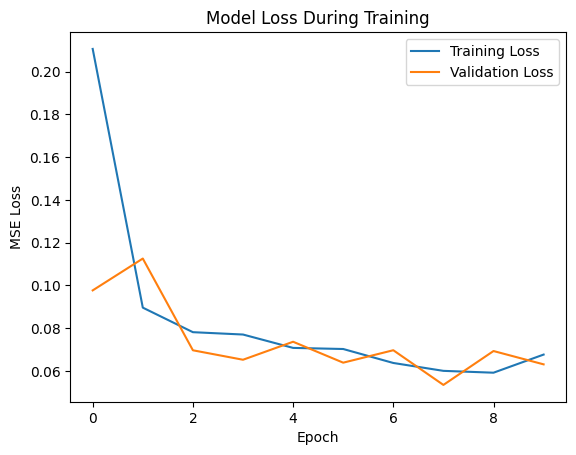

In [28]:
# Define the autoencoder model
def build_lstm_autoencoder(seq_length, n_features):
    # Encoder
    inputs = Input(shape=(seq_length, n_features))
    encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
    
    # Decoder
    decoded = RepeatVector(seq_length)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss=MeanAbsoluteError())
    
    return autoencoder

# Build and train the model
n_features = X_train.shape[2]
autoencoder = build_lstm_autoencoder(SEQ_LENGTH, n_features)
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
    shuffle=True
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss During Training')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.show()

In [29]:
# Calculate reconstruction error
def calculate_reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

# Get reconstruction errors
train_error = calculate_reconstruction_error(autoencoder, X_train)
val_error = calculate_reconstruction_error(autoencoder, X_val)

# Determine threshold (using 85th percentile of training errors)
threshold = np.percentile(train_error, 85)
print(f"Anomaly threshold: {threshold}")

# Function to detect anomalies
def detect_anomalies(model, data, threshold):
    errors = calculate_reconstruction_error(model, data)
    anomalies = errors > threshold
    return anomalies, errors

# Example usage (would use your actual test data with anomalies)
# anomalies, errors = detect_anomalies(autoencoder, test_sequences, threshold)

12097/12097 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Anomaly threshold: 0.006597613207211379


3025/3025 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


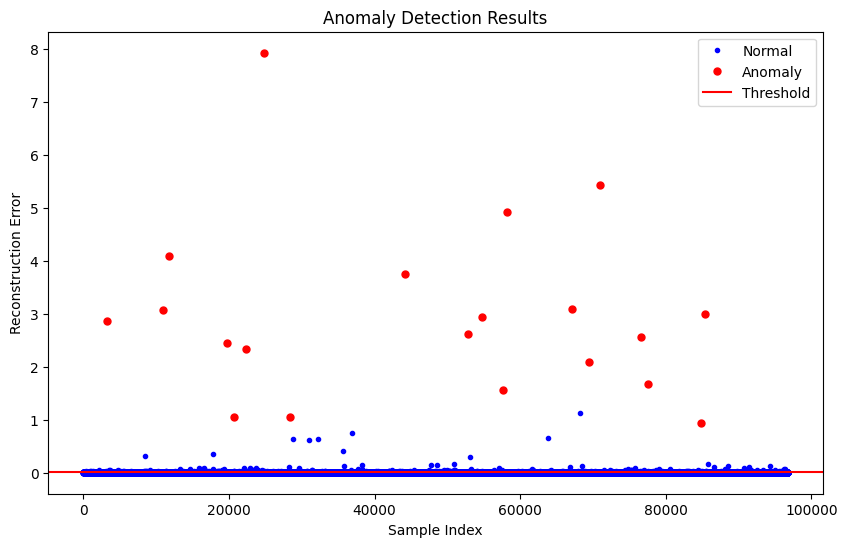

Detected 14512 anomalies out of 96775 samples
True anomalies: 20


In [30]:
# Create some synthetic anomalies for demonstration
np.random.seed(42)
anomaly_indices = np.random.choice(len(X_val), size=20, replace=False)
X_val_anomalies = X_val.copy()
X_val_anomalies[anomaly_indices] += np.random.normal(0, 2, size=(20, SEQ_LENGTH, n_features))

# Detect anomalies
anomalies, errors = detect_anomalies(autoencoder, X_val_anomalies, threshold)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(errors, 'bo', markersize=3, label='Normal')
plt.plot(anomaly_indices, errors[anomaly_indices], 'ro', markersize=5, label='Anomaly')
plt.axhline(y=threshold, color='r', linestyle='-', label='Threshold')
plt.title('Anomaly Detection Results')
plt.ylabel('Reconstruction Error')
plt.xlabel('Sample Index')
plt.legend()
plt.show()

print(f"Detected {np.sum(anomalies)} anomalies out of {len(X_val_anomalies)} samples")
print(f"True anomalies: {len(anomaly_indices)}")

In [31]:
from tensorflow.keras.models import save_model

# Save the entire model to a HDF5 file
save_model(autoencoder, 'lstm_autoencoder_anomaly_detection.h5')

print("Model saved successfully as 'lstm_autoencoder_anomaly_detection.h5'")

Model saved successfully as 'lstm_autoencoder_anomaly_detection.h5'


In [32]:
# Save only the weights
autoencoder.save_weights('lstm_autoencoder_weights.weights.h5')
print("Model weights saved successfully as 'lstm_autoencoder_weights.h5'")

Model weights saved successfully as 'lstm_autoencoder_weights.h5'


In [33]:
import json

# Save the model architecture as JSON
model_json = autoencoder.to_json()
with open("lstm_autoencoder_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved as 'lstm_autoencoder_architecture.json'")


Model architecture saved as 'lstm_autoencoder_architecture.json'


In [34]:
import joblib

# Save the scaler
joblib.dump(scaler, 'standard_scaler.save')

print("Scaler saved successfully as 'standard_scaler.save'")

Scaler saved successfully as 'standard_scaler.save'
